In [0]:
from __future__ import division
from __future__ import print_function

import os.path as osp
import numpy as np
from easydict import EasyDict as edict
import os


__C = edict()
cfg = __C

# Dataset name:  birds
__C.DATASET_NAME = 'birds'
__C.EMBEDDING_TYPE = 'cnn-rnn'
__C.CONFIG_NAME = ''
__C.GPU_ID = '0'
__C.CUDA = True
__C.WORKERS = 6

def get_lastest_stage1_g_path(stage1_g_path):
  model_prefix = 'netG_epoch_'
  try:
    generator_model_last_epoch = max(list(
        map(
            lambda x: int(x.rsplit('.', 1)[0].replace(model_prefix, '')),
            list(
                filter(
                    lambda x: model_prefix in x,
                    os.listdir(stage1_g_path)
                )
            )
        )
    ))
  except Exception as e:
    generator_model_last_epoch = None
  if generator_model_last_epoch is None:
    return ''
  generator_model_file = os.path.join(
      stage1_g_path,
      '{}{}.pth'.format(model_prefix, generator_model_last_epoch)
  )
  print(generator_model_file)
  return generator_model_file

__C.NET_G = ''
__C.NET_D = ''
__C.STAGE1_G = get_lastest_stage1_g_path('/content/drive/My Drive/output/birds__2020_05_17_11_11_26/Model')
__C.DATA_DIR = ''
__C.VIS_COUNT = 64

__C.Z_DIM = 100
__C.IMSIZE = 256
__C.STAGE = 2


# Training options
__C.TRAIN = edict()
__C.TRAIN.FLAG = True
__C.TRAIN.BATCH_SIZE = 64
__C.TRAIN.MAX_EPOCH = 600
__C.TRAIN.SNAPSHOT_INTERVAL = 50
__C.TRAIN.PRETRAINED_MODEL = ''
__C.TRAIN.PRETRAINED_EPOCH = 600
__C.TRAIN.LR_DECAY_EPOCH = 600
__C.TRAIN.DISCRIMINATOR_LR = 2e-4
__C.TRAIN.GENERATOR_LR = 2e-4

__C.TRAIN.COEFF = edict()
__C.TRAIN.COEFF.KL = 2.0

# Modal options
__C.GAN = edict()
__C.GAN.CONDITION_DIM = 128
__C.GAN.DF_DIM = 64
__C.GAN.GF_DIM = 128
__C.GAN.R_NUM = 4

__C.TEXT = edict()
__C.TEXT.DIMENSION = 1024


def _merge_a_into_b(a, b):
    """Merge config dictionary a into config dictionary b, clobbering the
    options in b whenever they are also specified in a.
    """
    if type(a) is not edict:
        return

    for k, v in a.iteritems():
        # a must specify keys that are in b
        if not b.has_key(k):
            raise KeyError('{} is not a valid config key'.format(k))

        # the types must match, too
        old_type = type(b[k])
        if old_type is not type(v):
            if isinstance(b[k], np.ndarray):
                v = np.array(v, dtype=b[k].dtype)
            else:
                raise ValueError(('Type mismatch ({} vs. {}) '
                                  'for config key: {}').format(type(b[k]),
                                                               type(v), k))

        # recursively merge dicts
        if type(v) is edict:
            try:
                _merge_a_into_b(a[k], b[k])
            except:
                print('Error under config key: {}'.format(k))
                raise
        else:
            b[k] = v


def cfg_from_file(filename):
    """Load a config file and merge it into the default options."""
    import yaml
    with open(filename, 'r') as f:
        yaml_cfg = edict(yaml.load(f))

    _merge_a_into_b(yaml_cfg, __C)

In [0]:
import matplotlib.pyplot as plt

In [0]:
import os
import errno
import numpy as np

from copy import deepcopy
# from miscc.config import cfg

from torch.nn import init
import torch
import torch.nn as nn
import torchvision.utils as vutils


#############################
def KL_loss(mu, logvar):
    # -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.mean(KLD_element).mul_(-0.5)
    return KLD


def compute_discriminator_loss(netD, real_imgs, fake_imgs,
                               real_labels, fake_labels,
                               conditions, gpus):
    criterion = nn.BCELoss()
    batch_size = real_imgs.size(0)
    cond = conditions.detach()
    fake = fake_imgs.detach()
    if cfg.CUDA:
      real_features = nn.parallel.data_parallel(netD, (real_imgs), gpus)
      fake_features = nn.parallel.data_parallel(netD, (fake), gpus)
    else:
      real_features = netD(real_imgs)
      fake_features = netD(fake)
    # real pairs
    inputs = (real_features, cond)
    if cfg.CUDA:
      real_logits = nn.parallel.data_parallel(netD.get_cond_logits, inputs, gpus)
    else:
      real_logits = netD.get_cond_logits(inputs[0], inputs[1])
    errD_real = criterion(real_logits, real_labels)
    # wrong pairs
    inputs = (real_features[:(batch_size-1)], cond[1:])
    if cfg.CUDA:
      wrong_logits = \
          nn.parallel.data_parallel(netD.get_cond_logits, inputs, gpus)
    else:
      wrong_logits = \
          netD.get_cond_logits(inputs[0], inputs[1])
    errD_wrong = criterion(wrong_logits, fake_labels[1:])
    # fake pairs
    inputs = (fake_features, cond)
    if cfg.CUDA:
      fake_logits = nn.parallel.data_parallel(netD.get_cond_logits, inputs, gpus)
    else:
      fake_logits = netD.get_cond_logits(inputs[0], inputs[1])
    errD_fake = criterion(fake_logits, fake_labels)

    if netD.get_uncond_logits is not None:
        if cfg.CUDA:
          real_logits = \
              nn.parallel.data_parallel(netD.get_uncond_logits,
                                        (real_features), gpus)
          fake_logits = \
              nn.parallel.data_parallel(netD.get_uncond_logits,
                                        (fake_features), gpus)
        else:
          real_logits = \
              netD.get_uncond_logits(real_features)
          fake_logits = \
              netD.get_uncond_logits(fake_features)
        uncond_errD_real = criterion(real_logits, real_labels)
        uncond_errD_fake = criterion(fake_logits, fake_labels)
        #
        errD = ((errD_real + uncond_errD_real) / 2. +
                (errD_fake + errD_wrong + uncond_errD_fake) / 3.)
        errD_real = (errD_real + uncond_errD_real) / 2.
        errD_fake = (errD_fake + uncond_errD_fake) / 2.
    else:
        errD = errD_real + (errD_fake + errD_wrong) * 0.5
    # print(errD.item(), errD_real.item(), errD_wrong.item(), errD_fake.item())
    return errD, errD_real.item(), errD_wrong.item(), errD_fake.item()


def compute_generator_loss(netD, fake_imgs, real_labels, conditions, gpus):
    criterion = nn.BCELoss()
    cond = conditions.detach()
    if cfg.CUDA:
      fake_features = nn.parallel.data_parallel(netD, (fake_imgs), gpus)
    else:
      fake_features = netD(fake_imgs)
    # fake pairs
    inputs = (fake_features, cond)
    if cfg.CUDA:
      fake_logits = nn.parallel.data_parallel(netD.get_cond_logits, inputs, gpus)
    else:
      fake_logits = netD.get_cond_logits(inputs[0], inputs[1])
    errD_fake = criterion(fake_logits, real_labels)
    if netD.get_uncond_logits is not None:
        if cfg.CUDA:
          fake_logits = \
              nn.parallel.data_parallel(netD.get_uncond_logits,
                                        (fake_features), gpus)
        else:
          fake_logits = \
              netD.get_uncond_logits(fake_features)
        uncond_errD_fake = criterion(fake_logits, real_labels)
        errD_fake += uncond_errD_fake
    return errD_fake


#############################
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.02)
        if m.bias is not None:
            m.bias.data.fill_(0.0)


#############################
def save_img_results(data_img, fake, epoch, image_dir):
    num = cfg.VIS_COUNT
    fake = fake[0:num]
    # data_img is changed to [0,1]
    if data_img is not None:
        data_img = data_img[0:num]
        vutils.save_image(
            data_img, '%s/real_samples.png' % image_dir,
            normalize=True)
        # fake.data is still [-1, 1]
        vutils.save_image(
            fake.data, '%s/fake_samples_epoch_%03d.png' %
            (image_dir, epoch), normalize=True)
    else:
        vutils.save_image(
            fake.data, '%s/lr_fake_samples_epoch_%03d.png' %
            (image_dir, epoch), normalize=True)


def save_model(netG, netD, epoch, model_dir):
    torch.save(
        netG.state_dict(),
        '%s/netG_epoch_%d.pth' % (model_dir, epoch))
    torch.save(
        netD.state_dict(),
        '%s/netD_epoch_last.pth' % (model_dir))
    print('Save G/D models')


def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        print(exc)
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals


import torch.utils.data as data
from PIL import Image
import PIL
import os
import os.path
import pickle
import random
import numpy as np
import pandas as pd

# from miscc.config import cfg
# 

class TextDataset(data.Dataset):
    def __init__(self, data_dir, split='train', embedding_type='cnn-rnn',
                 imsize=64, transform=None, target_transform=None):

        self.transform = transform
        self.target_transform = target_transform
        self.imsize = imsize
        self.data = []
        self.data_dir = data_dir
        print(self.data_dir, data_dir.find('birds'))
        if data_dir.find('birds') != -1:
            self.bbox = self.load_bbox()
        else:
            self.bbox = None
        split_dir = os.path.join(data_dir, split)

        self.filenames = self.load_filenames(split_dir)
        self.embeddings = self.load_embedding(split_dir, embedding_type)
        self.class_id = self.load_class_id(split_dir, len(self.filenames))
        # self.captions = self.load_all_captions()

    def get_img(self, img_path, bbox):
        img = Image.open(img_path).convert('RGB')
        width, height = img.size
        if bbox is not None:
            R = int(np.maximum(bbox[2], bbox[3]) * 0.75)
            center_x = int((2 * bbox[0] + bbox[2]) / 2)
            center_y = int((2 * bbox[1] + bbox[3]) / 2)
            y1 = np.maximum(0, center_y - R)
            y2 = np.minimum(height, center_y + R)
            x1 = np.maximum(0, center_x - R)
            x2 = np.minimum(width, center_x + R)
            img = img.crop([x1, y1, x2, y2])
        load_size = int(self.imsize * 76 / 64)
        img = img.resize((load_size, load_size), PIL.Image.BILINEAR)
        if self.transform is not None:
            img = self.transform(img)
        return img

    def load_bbox(self):
        print('here = ')
        data_dir = self.data_dir
        bbox_path = os.path.join(data_dir, 'CUB_200_2011/bounding_boxes.txt')
        print('abc = ', bbox_path)
        df_bounding_boxes = pd.read_csv(bbox_path,
                                        delim_whitespace=True,
                                        header=None).astype(int)
        #
        filepath = os.path.join(data_dir, 'CUB_200_2011/images.txt')
        df_filenames = \
            pd.read_csv(filepath, delim_whitespace=True, header=None)
        filenames = df_filenames[1].tolist()
        print('Total filenames: ', len(filenames), filenames[0])
        #
        filename_bbox = {img_file[:-4]: [] for img_file in filenames}
        numImgs = len(filenames)
        for i in range(0, numImgs):
            if i % 100 == 0:
              print(i)
            # bbox = [x-left, y-top, width, height]
            bbox = df_bounding_boxes.iloc[i][1:].tolist()

            key = filenames[i][:-4]
            filename_bbox[key] = bbox
        #
        return filename_bbox

    def load_all_captions(self):
        caption_dict = {}
        for key in self.filenames:
            caption_name = '%s/text/%s.txt' % (self.data_dir, key)
            captions = self.load_captions(caption_name)
            caption_dict[key] = captions
        return caption_dict

    def load_captions(self, caption_name):
        cap_path = caption_name
        with open(cap_path, "r") as f:
            captions = f.read().decode('utf8').split('\n')
        captions = [cap.replace("\ufffd\ufffd", " ")
                    for cap in captions if len(cap) > 0]
        return captions

    def load_embedding(self, data_dir, embedding_type):
        if embedding_type == 'cnn-rnn':
            embedding_filename = '/char-CNN-RNN-embeddings.pickle'
        elif embedding_type == 'cnn-gru':
            embedding_filename = '/char-CNN-GRU-embeddings.pickle'
        elif embedding_type == 'skip-thought':
            embedding_filename = '/skip-thought-embeddings.pickle'

        with open(data_dir + embedding_filename, 'rb') as f:
            embeddings = pickle.load(f, encoding='bytes')
            embeddings = np.array(embeddings)
            # embedding_shape = [embeddings.shape[-1]]
            print('embeddings: ', embeddings.shape)
        return embeddings

    def load_class_id(self, data_dir, total_num):
        if os.path.isfile(data_dir + '/class_info.pickle'):
            with open(data_dir + '/class_info.pickle', 'rb') as f:
                class_id = pickle.load(f, encoding='bytes')
        else:
            class_id = np.arange(total_num)
        return class_id

    def load_filenames(self, data_dir):
        filepath = os.path.join(data_dir, 'filenames.pickle')
        with open(filepath, 'rb') as f:
            filenames = pickle.load(f)
        print('Load filenames from: %s (%d)' % (filepath, len(filenames)))
        return filenames

    def __getitem__(self, index):
        key = self.filenames[index]
        # cls_id = self.class_id[index]
        #
        if self.bbox is not None:
            bbox = self.bbox[key]
            data_dir = '%s/CUB_200_2011' % self.data_dir
        else:
            bbox = None
            data_dir = self.data_dir

        # captions = self.captions[key]
        embeddings = self.embeddings[index, :, :]
        img_name = '%s/images/%s.jpg' % (data_dir, key)
        img = self.get_img(img_name, bbox)

        embedding_ix = random.randint(0, embeddings.shape[0]-1)
        embedding = embeddings[embedding_ix, :]
        if self.target_transform is not None:
            embedding = self.target_transform(embedding)
        return img, embedding

    def __len__(self):
        return len(self.filenames)

In [0]:
import torch
import torch.nn as nn
import torch.nn.parallel
# from miscc.config import cfg
from torch.autograd import Variable


def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


# Upsale the spatial size by a factor of 2
def upBlock(in_planes, out_planes):
    block = nn.Sequential(
        nn.Upsample(scale_factor=2, mode='nearest'),
        conv3x3(in_planes, out_planes),
        nn.BatchNorm2d(out_planes),
        nn.ReLU(True))
    return block


class ResBlock(nn.Module):
    def __init__(self, channel_num):
        super(ResBlock, self).__init__()
        self.block = nn.Sequential(
            conv3x3(channel_num, channel_num),
            nn.BatchNorm2d(channel_num),
            nn.ReLU(True),
            conv3x3(channel_num, channel_num),
            nn.BatchNorm2d(channel_num))
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        out = self.block(x)
        out += residual
        out = self.relu(out)
        return out


class CA_NET(nn.Module):
    # some code is modified from vae examples
    # (https://github.com/pytorch/examples/blob/master/vae/main.py)
    def __init__(self):
        super(CA_NET, self).__init__()
        self.t_dim = cfg.TEXT.DIMENSION
        self.c_dim = cfg.GAN.CONDITION_DIM
        self.fc = nn.Linear(self.t_dim, self.c_dim * 2, bias=True)
        self.relu = nn.ReLU()

    def encode(self, text_embedding):
        x = self.relu(self.fc(text_embedding))
        mu = x[:, :self.c_dim]
        logvar = x[:, self.c_dim:]
        return mu, logvar

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if cfg.CUDA:
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def forward(self, text_embedding):
        mu, logvar = self.encode(text_embedding)
        c_code = self.reparametrize(mu, logvar)
        return c_code, mu, logvar


class D_GET_LOGITS(nn.Module):
    def __init__(self, ndf, nef, bcondition=True):
        super(D_GET_LOGITS, self).__init__()
        self.df_dim = ndf
        self.ef_dim = nef
        self.bcondition = bcondition
        if bcondition:
            self.outlogits = nn.Sequential(
                conv3x3(ndf * 8 + nef, ndf * 8),
                nn.BatchNorm2d(ndf * 8),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=4),
                nn.Sigmoid())
        else:
            self.outlogits = nn.Sequential(
                nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=4),
                nn.Sigmoid())

    def forward(self, h_code, c_code=None):
        # conditioning output
        if self.bcondition and c_code is not None:
            c_code = c_code.view(-1, self.ef_dim, 1, 1)
            c_code = c_code.repeat(1, 1, 4, 4)
            # state size (ngf+egf) x 4 x 4
            h_c_code = torch.cat((h_code, c_code), 1)
        else:
            h_c_code = h_code

        output = self.outlogits(h_c_code)
        return output.view(-1)


# ############# Networks for stageI GAN #############
class STAGE1_G(nn.Module):
    def __init__(self):
        super(STAGE1_G, self).__init__()
        self.gf_dim = cfg.GAN.GF_DIM * 8
        self.ef_dim = cfg.GAN.CONDITION_DIM
        self.z_dim = cfg.Z_DIM
        self.define_module()

    def define_module(self):
        ninput = self.z_dim + self.ef_dim
        ngf = self.gf_dim
        # TEXT.DIMENSION -> GAN.CONDITION_DIM
        self.ca_net = CA_NET()

        # -> ngf x 4 x 4
        self.fc = nn.Sequential(
            nn.Linear(ninput, ngf * 4 * 4, bias=False),
            nn.BatchNorm1d(ngf * 4 * 4),
            nn.ReLU(True))

        # ngf x 4 x 4 -> ngf/2 x 8 x 8
        self.upsample1 = upBlock(ngf, ngf // 2)
        # -> ngf/4 x 16 x 16
        self.upsample2 = upBlock(ngf // 2, ngf // 4)
        # -> ngf/8 x 32 x 32
        self.upsample3 = upBlock(ngf // 4, ngf // 8)
        # -> ngf/16 x 64 x 64
        self.upsample4 = upBlock(ngf // 8, ngf // 16)
        # -> 3 x 64 x 64
        self.img = nn.Sequential(
            conv3x3(ngf // 16, 3),
            nn.Tanh())

    def forward(self, text_embedding, noise):
        c_code, mu, logvar = self.ca_net(text_embedding)
        z_c_code = torch.cat((noise, c_code), 1)
        h_code = self.fc(z_c_code)

        h_code = h_code.view(-1, self.gf_dim, 4, 4)
        h_code = self.upsample1(h_code)
        h_code = self.upsample2(h_code)
        h_code = self.upsample3(h_code)
        h_code = self.upsample4(h_code)
        # state size 3 x 64 x 64
        fake_img = self.img(h_code)
        return None, fake_img, mu, logvar


class STAGE1_D(nn.Module):
    def __init__(self):
        super(STAGE1_D, self).__init__()
        self.df_dim = cfg.GAN.DF_DIM
        self.ef_dim = cfg.GAN.CONDITION_DIM
        self.define_module()

    def define_module(self):
        ndf, nef = self.df_dim, self.ef_dim
        self.encode_img = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (ndf*2) x 16 x 16
            nn.Conv2d(ndf*2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (ndf*4) x 8 x 8
            nn.Conv2d(ndf*4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            # state size (ndf * 8) x 4 x 4)
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.get_cond_logits = D_GET_LOGITS(ndf, nef)
        self.get_uncond_logits = None

    def forward(self, image):
        img_embedding = self.encode_img(image)

        return img_embedding


# ############# Networks for stageII GAN #############
class STAGE2_G(nn.Module):
    def __init__(self, STAGE1_G):
        super(STAGE2_G, self).__init__()
        self.gf_dim = cfg.GAN.GF_DIM
        self.ef_dim = cfg.GAN.CONDITION_DIM
        self.z_dim = cfg.Z_DIM
        self.STAGE1_G = STAGE1_G
        # fix parameters of stageI GAN
        for param in self.STAGE1_G.parameters():
            param.requires_grad = False
        self.define_module()

    def _make_layer(self, block, channel_num):
        layers = []
        for i in range(cfg.GAN.R_NUM):
            layers.append(block(channel_num))
        return nn.Sequential(*layers)

    def define_module(self):
        ngf = self.gf_dim
        # TEXT.DIMENSION -> GAN.CONDITION_DIM
        self.ca_net = CA_NET()
        # --> 4ngf x 16 x 16
        self.encoder = nn.Sequential(
            conv3x3(3, ngf),
            nn.ReLU(True),
            nn.Conv2d(ngf, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.Conv2d(ngf * 2, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True))
        self.hr_joint = nn.Sequential(
            conv3x3(self.ef_dim + ngf * 4, ngf * 4),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True))
        self.residual = self._make_layer(ResBlock, ngf * 4)
        # --> 2ngf x 32 x 32
        self.upsample1 = upBlock(ngf * 4, ngf * 2)
        # --> ngf x 64 x 64
        self.upsample2 = upBlock(ngf * 2, ngf)
        # --> ngf // 2 x 128 x 128
        self.upsample3 = upBlock(ngf, ngf // 2)
        # --> ngf // 4 x 256 x 256
        self.upsample4 = upBlock(ngf // 2, ngf // 4)
        # --> 3 x 256 x 256
        self.img = nn.Sequential(
            conv3x3(ngf // 4, 3),
            nn.Tanh())

    def forward(self, text_embedding, noise):
        _, stage1_img, _, _ = self.STAGE1_G(text_embedding, noise)
        stage1_img = stage1_img.detach()
        encoded_img = self.encoder(stage1_img)

        c_code, mu, logvar = self.ca_net(text_embedding)
        c_code = c_code.view(-1, self.ef_dim, 1, 1)
        c_code = c_code.repeat(1, 1, 16, 16)
        i_c_code = torch.cat([encoded_img, c_code], 1)
        h_code = self.hr_joint(i_c_code)
        h_code = self.residual(h_code)

        h_code = self.upsample1(h_code)
        h_code = self.upsample2(h_code)
        h_code = self.upsample3(h_code)
        h_code = self.upsample4(h_code)

        fake_img = self.img(h_code)
        return stage1_img, fake_img, mu, logvar


class STAGE2_D(nn.Module):
    def __init__(self):
        super(STAGE2_D, self).__init__()
        self.df_dim = cfg.GAN.DF_DIM
        self.ef_dim = cfg.GAN.CONDITION_DIM
        self.define_module()

    def define_module(self):
        ndf, nef = self.df_dim, self.ef_dim
        self.encode_img = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),  # 128 * 128 * ndf
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),  # 64 * 64 * ndf * 2
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),  # 32 * 32 * ndf * 4
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),  # 16 * 16 * ndf * 8
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),  # 8 * 8 * ndf * 16
            nn.Conv2d(ndf * 16, ndf * 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 32),
            nn.LeakyReLU(0.2, inplace=True),  # 4 * 4 * ndf * 32
            conv3x3(ndf * 32, ndf * 16),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),   # 4 * 4 * ndf * 16
            conv3x3(ndf * 16, ndf * 8),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True)   # 4 * 4 * ndf * 8
        )

        self.get_cond_logits = D_GET_LOGITS(ndf, nef, bcondition=True)
        self.get_uncond_logits = D_GET_LOGITS(ndf, nef, bcondition=False)

    def forward(self, image):
        img_embedding = self.encode_img(image)

        return img_embedding

In [0]:
from __future__ import print_function
from six.moves import range
from PIL import Image

import torch.backends.cudnn as cudnn
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import os
import time

import numpy as np
# import torchfile

# from miscc.config import cfg
# from miscc.utils import mkdir_p
# from miscc.utils import weights_init
# from miscc.utils import save_img_results, save_model
# from miscc.utils import KL_loss
# from miscc.utils import compute_discriminator_loss, compute_generator_loss

# from tensorboard import summary
# from tensorboard import FileWriter


class GANTrainer(object):
    def __init__(self, output_dir):
        if cfg.TRAIN.FLAG:
            self.model_dir = os.path.join(output_dir, 'Model')
            self.image_dir = os.path.join(output_dir, 'Image')
            self.log_dir = os.path.join(output_dir, 'Log')
            mkdir_p(self.model_dir)
            mkdir_p(self.image_dir)
            mkdir_p(self.log_dir)
            # self.summary_writer = FileWriter(self.log_dir)

        self.max_epoch = cfg.TRAIN.MAX_EPOCH
        self.snapshot_interval = cfg.TRAIN.SNAPSHOT_INTERVAL

        s_gpus = cfg.GPU_ID.split(',')
        self.gpus = [int(ix) for ix in s_gpus]
        self.num_gpus = len(self.gpus)
        self.batch_size = cfg.TRAIN.BATCH_SIZE * self.num_gpus
        if cfg.CUDA:
          torch.cuda.set_device(self.gpus[0])
          cudnn.benchmark = True

    # ############# For training stageI GAN #############
    def load_network_stageI(self):
        # from model import STAGE1_G, STAGE1_D
        netG = STAGE1_G()
        netG.apply(weights_init)
        print(netG)
        netD = STAGE1_D()
        netD.apply(weights_init)
        print(netD)

        if cfg.NET_G != '':
            state_dict = \
                torch.load(cfg.NET_G,
                           map_location=lambda storage, loc: storage)
            netG.load_state_dict(state_dict)
            print('Load from: ', cfg.NET_G)
        if cfg.NET_D != '':
            state_dict = \
                torch.load(cfg.NET_D,
                           map_location=lambda storage, loc: storage)
            netD.load_state_dict(state_dict)
            print('Load from: ', cfg.NET_D)
        if cfg.CUDA:
            netG.cuda()
            netD.cuda()
        return netG, netD

    # ############# For training stageII GAN  #############
    def load_network_stageII(self):
        # from model import STAGE1_G, STAGE2_G, STAGE2_D

        Stage1_G = STAGE1_G()
        netG = STAGE2_G(Stage1_G)
        netG.apply(weights_init)
        print(netG)
        if cfg.NET_G != '':
            state_dict = \
                torch.load(cfg.NET_G,
                           map_location=lambda storage, loc: storage)
            netG.load_state_dict(state_dict)
            print('Load from: ', cfg.NET_G)
        elif cfg.STAGE1_G != '':
            state_dict = \
                torch.load(cfg.STAGE1_G,
                           map_location=lambda storage, loc: storage)
            netG.STAGE1_G.load_state_dict(state_dict)
            print('Load from: ', cfg.STAGE1_G)
        else:
            print("Please give the Stage1_G path")
            return

        netD = STAGE2_D()
        netD.apply(weights_init)
        if cfg.NET_D != '':
            state_dict = \
                torch.load(cfg.NET_D,
                           map_location=lambda storage, loc: storage)
            netD.load_state_dict(state_dict)
            print('Load from: ', cfg.NET_D)
        print(netD)

        if cfg.CUDA:
            netG.cuda()
            netD.cuda()
        return netG, netD

    def train(self, data_loader, stage=1):
        if stage == 1:
            netG, netD = self.load_network_stageI()
        else:
            netG, netD = self.load_network_stageII()

        nz = cfg.Z_DIM
        batch_size = self.batch_size
        noise = Variable(torch.FloatTensor(batch_size, nz))
        fixed_noise = \
            Variable(torch.FloatTensor(batch_size, nz).normal_(0, 1),
                     volatile=True)
        real_labels = Variable(torch.FloatTensor(batch_size).fill_(1))
        fake_labels = Variable(torch.FloatTensor(batch_size).fill_(0))
        if cfg.CUDA:
            noise, fixed_noise = noise.cuda(), fixed_noise.cuda()
            real_labels, fake_labels = real_labels.cuda(), fake_labels.cuda()

        generator_lr = cfg.TRAIN.GENERATOR_LR
        discriminator_lr = cfg.TRAIN.DISCRIMINATOR_LR
        lr_decay_step = cfg.TRAIN.LR_DECAY_EPOCH
        optimizerD = \
            optim.Adam(netD.parameters(),
                       lr=cfg.TRAIN.DISCRIMINATOR_LR, betas=(0.5, 0.999))
        netG_para = []
        for p in netG.parameters():
            if p.requires_grad:
                netG_para.append(p)
        optimizerG = optim.Adam(netG_para,
                                lr=cfg.TRAIN.GENERATOR_LR,
                                betas=(0.5, 0.999))
        count = 0
        for epoch in range(self.max_epoch):
            start_t = time.time()
            if epoch % lr_decay_step == 0 and epoch > 0:
                generator_lr *= 0.5
                for param_group in optimizerG.param_groups:
                    param_group['lr'] = generator_lr
                discriminator_lr *= 0.5
                for param_group in optimizerD.param_groups:
                    param_group['lr'] = discriminator_lr

            for i, data in enumerate(data_loader, 0):
                ######################################################
                # (1) Prepare training data
                ######################################################
                real_img_cpu, txt_embedding = data
                real_imgs = Variable(real_img_cpu)
                txt_embedding = Variable(txt_embedding)
                if cfg.CUDA:
                    real_imgs = real_imgs.cuda()
                    txt_embedding = txt_embedding.cuda()

                #######################################################
                # (2) Generate fake images
                ######################################################
                noise.data.normal_(0, 1)
                inputs = (txt_embedding, noise)
                if cfg.CUDA:
                  _, fake_imgs, mu, logvar = \
                      nn.parallel.data_parallel(netG, inputs, self.gpus)
                else:
                  _, fake_imgs, mu, logvar = \
                      netG(inputs[0], inputs[1])

                ############################
                # (3) Update D network
                ###########################
                netD.zero_grad()
                errD, errD_real, errD_wrong, errD_fake = \
                    compute_discriminator_loss(netD, real_imgs, fake_imgs,
                                               real_labels, fake_labels,
                                               mu, self.gpus)
                errD.backward()
                optimizerD.step()
                ############################
                # (2) Update G network
                ###########################
                netG.zero_grad()
                errG = compute_generator_loss(netD, fake_imgs,
                                              real_labels, mu, self.gpus)
                kl_loss = KL_loss(mu, logvar)
                errG_total = errG + kl_loss * cfg.TRAIN.COEFF.KL
                errG_total.backward()
                optimizerG.step()

                count = count + 1
                # if epoch % 20 == 0:
                #     summary_D = summary.scalar('D_loss', errD.data[0])
                #     summary_D_r = summary.scalar('D_loss_real', errD_real)
                #     summary_D_w = summary.scalar('D_loss_wrong', errD_wrong)
                #     summary_D_f = summary.scalar('D_loss_fake', errD_fake)
                #     summary_G = summary.scalar('G_loss', errG.data[0])
                #     summary_KL = summary.scalar('KL_loss', kl_loss.data[0])

                    # self.summary_writer.add_summary(summary_D, count)
                    # self.summary_writer.add_summary(summary_D_r, count)
                    # self.summary_writer.add_summary(summary_D_w, count)
                    # self.summary_writer.add_summary(summary_D_f, count)
                    # self.summary_writer.add_summary(summary_G, count)
                    # self.summary_writer.add_summary(summary_KL, count)

                    # save the image result for each epoch
                    # inputs = (txt_embedding, fixed_noise)
                    # lr_fake, fake, _, _ = \
                    #     nn.parallel.data_parallel(netG, inputs, self.gpus)
                    # plt.imshow(np.moveaxis(fake[0].cpu().detach().numpy(), 0, -1))
                    # plt.pause(0.1)
                    # save_img_results(real_img_cpu, fake, epoch, self.image_dir)
                    # if lr_fake is not None:
                    #     save_img_results(None, lr_fake, epoch, self.image_dir)
            end_t = time.time()
            print('''[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f Loss_KL: %.4f
                     Loss_real: %.4f Loss_wrong:%.4f Loss_fake %.4f
                     Total Time: %.2fsec
                  '''
                  % (epoch, self.max_epoch, i, len(data_loader),
                     errD.item(), errG.item(), kl_loss.item(),
                     errD_real, errD_wrong, errD_fake, (end_t - start_t)))
            if epoch % 1 == 0:
              inputs = (txt_embedding, fixed_noise)
              if cfg.CUDA:
                lr_fake, fake, _, _ = \
                    nn.parallel.data_parallel(netG, inputs, self.gpus)
              else:
                lr_fake, fake, _, _ = \
                    netG(inputs[0], inputs[1])
              plt.imshow(np.moveaxis(fake[0].cpu().detach().numpy(), 0, -1))
              plt.pause(0.1)
              
            if epoch % self.snapshot_interval == 0:
                save_model(netG, netD, epoch, self.model_dir)
        #
        save_model(netG, netD, self.max_epoch, self.model_dir)
        #
        # self.summary_writer.close()

    def sample(self, datapath, stage=1):
        if stage == 1:
            netG, _ = self.load_network_stageI()
        else:
            netG, _ = self.load_network_stageII()
        netG.eval()

        # Load text embeddings generated from the encoder
        t_file = torchfile.load(datapath)
        captions_list = t_file.raw_txt
        embeddings = np.concatenate(t_file.fea_txt, axis=0)
        num_embeddings = len(captions_list)
        print('Successfully load sentences from: ', datapath)
        print('Total number of sentences:', num_embeddings)
        print('num_embeddings:', num_embeddings, embeddings.shape)
        # path to save generated samples
        save_dir = cfg.NET_G[:cfg.NET_G.find('.pth')]
        mkdir_p(save_dir)

        batch_size = np.minimum(num_embeddings, self.batch_size)
        nz = cfg.Z_DIM
        noise = Variable(torch.FloatTensor(batch_size, nz))
        if cfg.CUDA:
            noise = noise.cuda()
        count = 0
        while count < num_embeddings:
            if count > 3000:
                break
            iend = count + batch_size
            if iend > num_embeddings:
                iend = num_embeddings
                count = num_embeddings - batch_size
            embeddings_batch = embeddings[count:iend]
            # captions_batch = captions_list[count:iend]
            txt_embedding = Variable(torch.FloatTensor(embeddings_batch))
            if cfg.CUDA:
                txt_embedding = txt_embedding.cuda()

            #######################################################
            # (2) Generate fake images
            ######################################################
            noise.data.normal_(0, 1)
            inputs = (txt_embedding, noise)
            if cfg.CUDA:
              _, fake_imgs, mu, logvar = \
                  nn.parallel.data_parallel(netG, inputs, self.gpus)
            else:
              _, fake_imgs, mu, logvar = \
                  nn(netG, inputs)
            for i in range(batch_size):
                save_name = '%s/%d.png' % (save_dir, count + i)
                im = fake_imgs[i].data.cpu().numpy()
                im = (im + 1.0) * 127.5
                im = im.astype(np.uint8)
                # print('im', im.shape)
                im = np.transpose(im, (1, 2, 0))
                # print('im', im.shape)
                im = Image.fromarray(im)
                # im.save(save_name)
            count += batch_size

In [0]:
!wget http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz

--2020-05-17 15:36:32--  http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz
Resolving www.vision.caltech.edu (www.vision.caltech.edu)... 34.208.54.77
Connecting to www.vision.caltech.edu (www.vision.caltech.edu)|34.208.54.77|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1150585339 (1.1G) [application/x-tar]
Saving to: ‘CUB_200_2011.tgz’

CUB_200_2011.tgz    100%[===================>]   1.07G  46.4MB/s    in 34s     

2020-05-17 15:37:06 (32.0 MB/s) - ‘CUB_200_2011.tgz’ saved [1150585339/1150585339]



In [0]:
import tarfile
tar = tarfile.open("CUB_200_2011.tgz")
tar.extractall()
tar.close()

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp /content/drive/My\ Drive/birds.zip ./
!unzip birds.zip

Archive:  birds.zip
replace birds/readme? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
! mkdir data 
! mv ./birds/* ./data
! mv ./CUB_200_2011 ./data
! mv data/* birds/

In [0]:
!ls

attributes.txt	birds  birds.zip  CUB_200_2011.tgz  data  drive  sample_data


In [0]:
from __future__ import print_function
import torch.backends.cudnn as cudnn
import torch
import torchvision.transforms as transforms

import argparse
import os
import random
import sys
import pprint
import datetime
import dateutil
import dateutil.tz
from easydict import EasyDict
import pathlib


# dir_path = (os.path.abspath(os.path.join(os.path.realpath(__file__), './.')))
# sys.path.append(dir_path)

# from miscc.datasets import TextDataset
# from miscc.config import cfg, cfg_from_file
# from miscc.utils import mkdir_p
# from trainer import GANTrainer


def parse_args():
    # parser = argparse.ArgumentParser(description='Train a GAN network')
    # parser.add_argument('--cfg', dest='cfg_file',
    #                     help='optional config file',
    #                     default='birds_stage1.yml', type=str)
    # parser.add_argument('--gpu',  dest='gpu_id', type=str, default='0')
    # parser.add_argument('--data_dir', dest='data_dir', type=str, default='')
    # parser.add_argument('--manualSeed', type=int, help='manual seed')
    # args = parser.parse_args()

    args = EasyDict()
    args.cfg_file = None
    args.gpu_id = '0'
    args.data_dir = 'birds'
    args.manualSeed = 1900

    return args

# if __name__ == "__main__":
args = parse_args()
if args.cfg_file is not None:
    cfg_from_file(args.cfg_file)
if args.gpu_id != -1:
    cfg.GPU_ID = args.gpu_id
if args.data_dir != '':
    cfg.DATA_DIR = args.data_dir

print(get_lastest_stage1_g_path('/content/drive/My Drive/output/birds__2020_05_17_11_11_26/Model'))
print('Using config:')
pprint.pprint(cfg)
if args.manualSeed is None:
    args.manualSeed = random.randint(1, 10000)
random.seed(args.manualSeed)
torch.manual_seed(args.manualSeed)
if cfg.CUDA:
    torch.cuda.manual_seed_all(args.manualSeed)
now = datetime.datetime.now(dateutil.tz.tzlocal())
timestamp = now.strftime('%Y_%m_%d_%H_%M_%S')
output_dir = '/content/drive/My Drive/output/%s_%s_%s' % \
              (cfg.DATASET_NAME, cfg.CONFIG_NAME, timestamp)

pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
print(output_dir)
num_gpu = len(cfg.GPU_ID.split(','))

/content/drive/My Drive/output/birds__2020_05_17_11_11_26/Model/netG_epoch_600.pth
/content/drive/My Drive/output/birds__2020_05_17_11_11_26/Model/netG_epoch_600.pth
Using config:
{'CONFIG_NAME': '',
 'CUDA': True,
 'DATASET_NAME': 'birds',
 'DATA_DIR': 'birds',
 'EMBEDDING_TYPE': 'cnn-rnn',
 'GAN': {'CONDITION_DIM': 128, 'DF_DIM': 64, 'GF_DIM': 128, 'R_NUM': 4},
 'GPU_ID': '0',
 'IMSIZE': 256,
 'NET_D': '',
 'NET_G': '',
 'STAGE': 2,
 'STAGE1_G': '/content/drive/My '
             'Drive/output/birds__2020_05_17_11_11_26/Model/netG_epoch_600.pth',
 'TEXT': {'DIMENSION': 1024},
 'TRAIN': {'BATCH_SIZE': 64,
           'COEFF': {'KL': 2.0},
           'DISCRIMINATOR_LR': 0.0002,
           'FLAG': True,
           'GENERATOR_LR': 0.0002,
           'LR_DECAY_EPOCH': 600,
           'MAX_EPOCH': 600,
           'PRETRAINED_EPOCH': 600,
           'PRETRAINED_MODEL': '',
           'SNAPSHOT_INTERVAL': 50},
 'VIS_COUNT': 64,
 'WORKERS': 6,
 'Z_DIM': 100}
/content/drive/My Drive/output/birds

In [0]:
if cfg.TRAIN.FLAG:
    image_transform = transforms.Compose([
        transforms.RandomCrop(cfg.IMSIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    dataset = TextDataset(cfg.DATA_DIR, 'train',
                          imsize=cfg.IMSIZE,
                          transform=image_transform)
    assert dataset
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=cfg.TRAIN.BATCH_SIZE * num_gpu,
        drop_last=True, shuffle=True, num_workers=int(cfg.WORKERS))

    algo = GANTrainer(output_dir)
    algo.train(dataloader, cfg.STAGE)
else:
    datapath= '%s/test/val_captions.t7' % (cfg.DATA_DIR)
    algo = GANTrainer(output_dir)
    algo.sample(datapath, cfg.STAGE)

[Errno 17] File exists: '/content/drive/My Drive/output/birds__2020_05_17_15_40_31/Model'
[Errno 17] File exists: '/content/drive/My Drive/output/birds__2020_05_17_15_40_31/Image'
[Errno 17] File exists: '/content/drive/My Drive/output/birds__2020_05_17_15_40_31/Log'
STAGE2_G(
  (STAGE1_G): STAGE1_G(
    (ca_net): CA_NET(
      (fc): Linear(in_features=1024, out_features=256, bias=True)
      (relu): ReLU()
    )
    (fc): Sequential(
      (0): Linear(in_features=228, out_features=16384, bias=False)
      (1): BatchNorm1d(16384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (upsample1): Sequential(
      (0): Upsample(scale_factor=2.0, mode=nearest)
      (1): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU(inplace=True)
    )
    (upsample2): Sequential(
      (0): Upsample(scale_factor=2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:120: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/600][137/138] Loss_D: 1.1833 Loss_G: 4.0044 Loss_KL: 0.0036
                     Loss_real: 0.5657 Loss_wrong:0.6699 Loss_fake 0.5915
                     Total Time: 139.09sec
                  


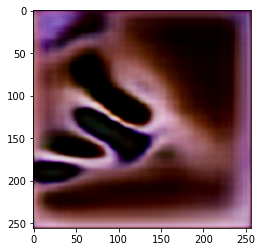

Save G/D models


In [0]:
algo = GANTrainer(output_dir)
algo.train(dataloader, cfg.STAGE)

In [0]:
import gc
gc.collect()
del algo